In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos

In [2]:
range_seasons = range(1999, 2026) # 1999-2025 seasons
df = nfl.import_schedules(range_seasons)

In [18]:
# r = nfl.import_team_desc() ## Equipos
# r = nfl.import_combine_data([2025])

In [3]:
shape = df.shape
print(f'Dataframe with {shape[0]:,} rows and {shape[1]} columns')

Dataframe with 7,276 rows and 46 columns


In [4]:
df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43,CLE,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24,GB,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14,IND,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


In [5]:
# Columns with NA's
# Existen columnas con NA, algunas no las utilizaremos para el modelo, por lo que no es un gran problema, pero es importante conocerlas.
np.round(df.isna().sum()[df.isna().sum() > 0] / len(df) * 100, 1)

gametime             3.6
nfl_detail_id       96.3
pff                 37.3
ftn                 77.3
away_moneyline      27.2
home_moneyline      27.2
away_spread_odds    27.2
home_spread_odds    27.2
under_odds          27.3
over_odds           27.3
surface              0.6
temp                28.4
wind                28.4
referee              0.0
dtype: float64

In [6]:
t = df.copy().drop(['nfl_detail_id', 'pff', 'ftn', 'away_moneyline', 'home_moneyline', 'away_spread_odds', 'home_spread_odds', 'over_odds', 'under_odds'], axis = 1)
# Create a binary target variable for home team win wich will be our target variable for modeling. It will be 1 if the home team won and 0 otherwise.
t['home_team_win'] = (t['home_score'] > t['away_score']).astype(int)

## Análisis exploratorio: 
Entendiendo las variables

In [7]:
season = t.groupby(['season']).agg({'away_score': 'mean', 'home_score': 'mean', 'home_team_win': 'mean'}).reset_index()
label_size = 9

### Linechart: Home vs Away Score

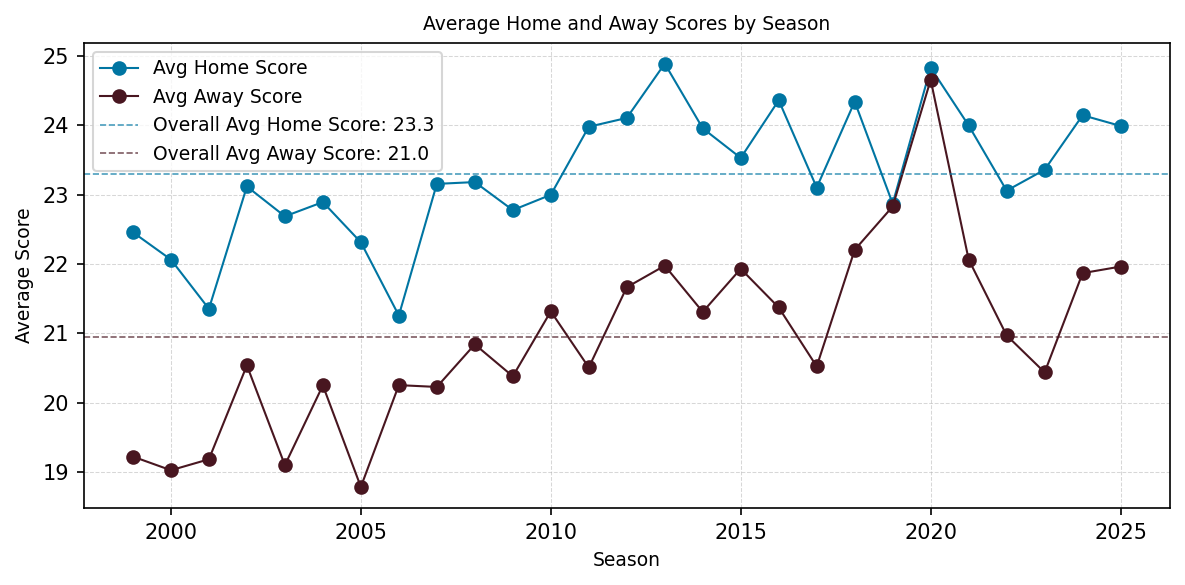

In [8]:

avg_home = t['home_score'].mean()
avg_away = t['away_score'].mean()

# Plot: Comparativa de scores home vs away por temporada, la idea es ver si hay alguna tendencia a lo largo de los años, y también comparar con el promedio general.
# Lo que se observa es que en promedio el equipo local marca 23.3 pts mientras que el equipo visitante marca 21 pts. Esto nos da indicio de que la localía pesa en un partido.
# Adicional, en las temporadas 2019 y 2020 hubo un caso "atípico" ya que los promedios se acercaron bastante.

fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)

plt.plot(season['season'], season['home_score'], marker = 'o', color = '#0075A2', label = 'Avg Home Score', linewidth = 1) 
plt.plot(season['season'], season['away_score'], marker = 'o', color = '#481620', label = 'Avg Away Score', linewidth = 1) #481620

ax.axhline(avg_home, color = '#0075A2', linestyle = '--', alpha = 0.7, label = f'Overall Avg Home Score: {avg_home:.1f}', linewidth = 0.8)
ax.axhline(avg_away, color = '#481620', linestyle = '--', alpha = 0.7, label = f'Overall Avg Away Score: {avg_away:.1f}', linewidth = 0.8)

ax.set_xlabel('Season', fontsize = label_size)
ax.set_ylabel('Average Score', fontsize = label_size)
ax.set_title('Average Home and Away Scores by Season', fontsize = label_size)
ax.legend(fontsize = label_size, loc = 'upper left')
ax.grid(axis = 'both', linestyle = '--', alpha = 0.5, linewidth = 0.5, zorder = -1)
plt.tight_layout()
plt.show()


### Tasa de victorias

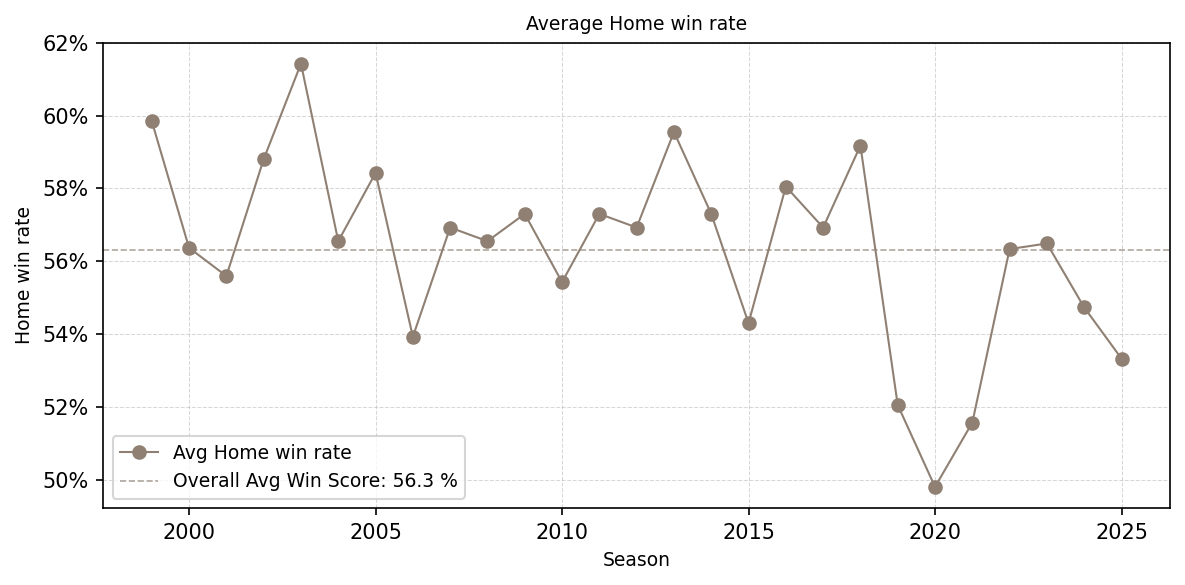

In [9]:

home_win = t['home_team_win'].mean() 

fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)

plt.plot(season['season'], season['home_team_win'], marker = 'o', color = '#8F8073', label = 'Avg Home win rate', linewidth = 1) 
ax.axhline(home_win, color = '#8F8073', linestyle = '--', alpha = 0.7, label = f'Overall Avg Win Score: {home_win*100:.1f} %', linewidth = 0.8)

ax.set_xlabel('Season', fontsize = label_size)
ax.set_ylabel('Home win rate', fontsize = label_size)
ax.set_title('Average Home win rate', fontsize = label_size)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}')) # Formatear el eje y como porcentaje

ax.legend(fontsize = label_size, loc = 'lower left')
ax.grid(axis = 'both', linestyle = '--', alpha = 0.5, linewidth = 0.5, zorder = -1)
plt.tight_layout()
plt.show()

### Home & Away Score por tipo de partido

In [10]:
# El 95% de los partidos son REG: temporada regular, lo cual tiene sentido totalmente. 

# | Partido único de aquí en adelante
# 1.64% Wild Cards 
# 1.48% Divisionales
# 0.74% Conferencia
# 0.37% Super Bowl

# La pregunta importante en esta parte del análisis y saber ¿Qué queremos modelar?
# En primera instancia vamos a modelar la temporada regular, buscamos predecir resultados de partidos de temporada REG.
# Más adelante podríamos modelar los partidos de postemporada, pero por ahora nos enfocaremos en la temporada regular. Es el 95% de los datos con los que contamos.
# Observemos los porcentajes de cada tipo de partido:

t['game_type'].value_counts(normalize = True) * 100

REG    95.753161
WC      1.649258
DIV     1.484332
CON     0.742166
SB      0.371083
Name: game_type, dtype: float64

In [11]:
# Se observa una diferencia en la tasa de victoria del equipo local entre tipo de partido 
# REG se mantiene constante con el 56% que veíamos antes. 
# En partidos de eliminación (post temporada) comienza a haber un cambio, los WC tienen una tasa de victoria del equipo local del 58% en promedio. 
# Los partidos divisionales tienen un 69% 
# Los partidos de CON tienen un 66%
# Los partidos de SB es el caso más atípico, con un 37% aunque aquí tenemos muchos ceros, esto mueve el promedio.

wrst = t.groupby(['season', 'game_type'])['home_team_win'].mean().unstack()
wrst.mean()

game_type
CON    0.666667
DIV    0.694444
REG    0.560767
SB     0.370370
WC     0.586420
dtype: float64

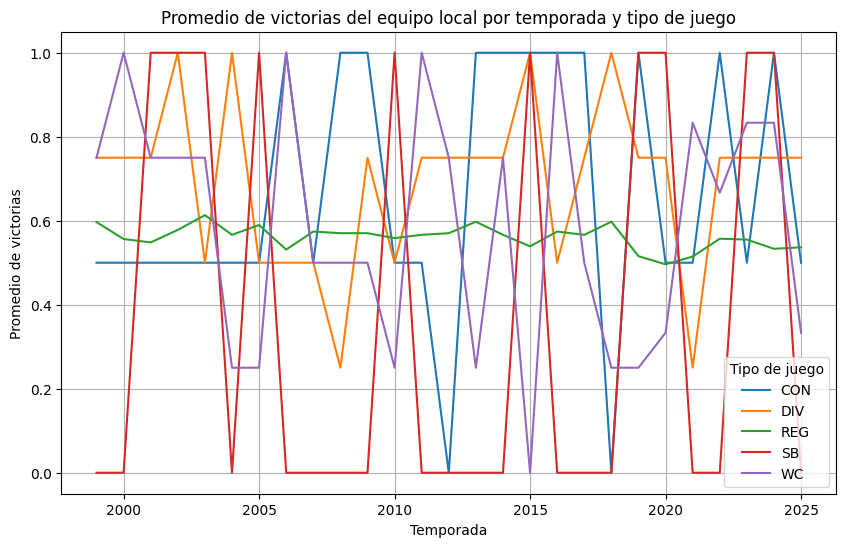

In [12]:
import matplotlib.pyplot as plt

# Excluir la columna 'SB' del DataFrame
wrst_filtered = wrst.drop(columns=[''], errors='ignore')

# Crear el gráfico de líneas
wrst_filtered.plot(kind='line', figsize=(10, 6))

# Configurar etiquetas y título
plt.title('Promedio de victorias del equipo local por temporada y tipo de juego')
plt.xlabel('Temporada')
plt.ylabel('Promedio de victorias')
plt.legend(title='Tipo de juego')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Por lo anterior, el modelo se enfocará en temporada regular, más adelante podemos incluir los otros tipos de juegos, generar un modelo para WC, DIV, CON y SB o validar nuestro modelo con data REG vs este tipo de juegos, para tratar de validar qué tan bien generalizamos.

### Semanas de juego x Temporada

In [13]:
t = t.query("game_type == 'REG'").copy()

# Weeks x Season: En 2021 se agregó un partido más a la temporada regular, pasando de 17 partidos a 18 partidos por equipo. 
# Esto se traduce en un aumento de semanas de temporada regular. Mayor desgaste para algunos equipos (previo a juegos post temporada).
# Algunos equipos aprovechan para dar descanso a algunos jugadores en la última semana, lo que puede afectar el resultado de ese partido. 

wxs = t.groupby(['season'])['week'].nunique()

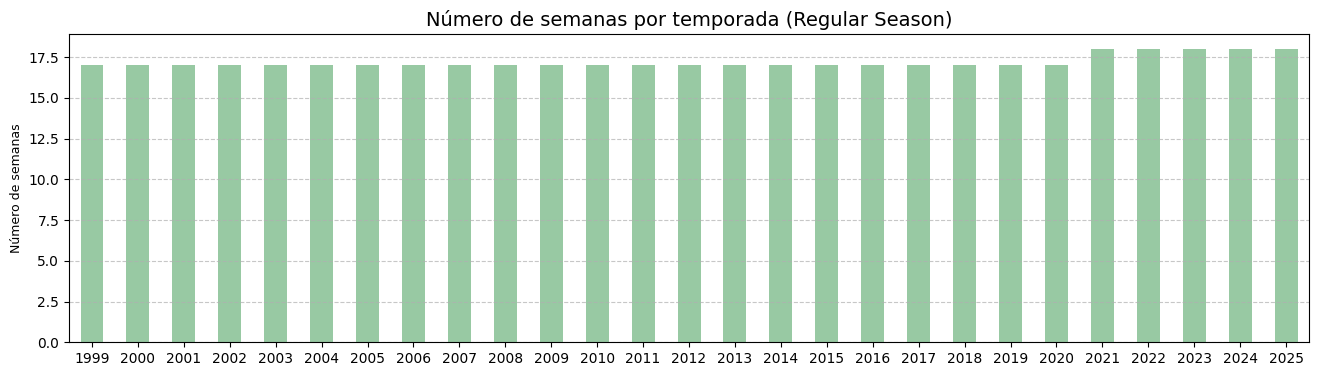

In [14]:
# Crear el gráfico de barras
wxs.plot(kind='bar', figsize=(16, 4), color='#98C9A3')

# Configurar etiquetas y título
plt.title('Número de semanas por temporada (Regular Season)', fontsize=14)
plt.xlabel('', fontsize=label_size)
plt.ylabel('Número de semanas', fontsize=label_size)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

### Número de juegos por temporada

Existen dos observaciones importantes para esta parte:
1. Temporada 2002: Se agregó la franquicia de los Houston Texans pasando de 31 a 32 equipos y pasando de 248 a 256 juegos por temporada. 
2. Temporada de 2021: Se agregó una semana adicional, por lo que cada equipo juega un partido adicional, pasando de 256 a 272 partidos por temporada. 

Obs: en 2022 se tuvieron 271 juegos, investigando encontré que en ese año se canceló el juego Bills vs Bengals esto debido a que Damar Hamlin, safety de los Buffalo Bills, sufrió un paro cardíaco el 2 de enero de 2023 tras un choque directo en el pecho durante un partido de la NFL.

In [15]:
season = t.groupby(['season'], as_index= False).agg({'game_id': 'nunique', 'home_team': 'nunique'})

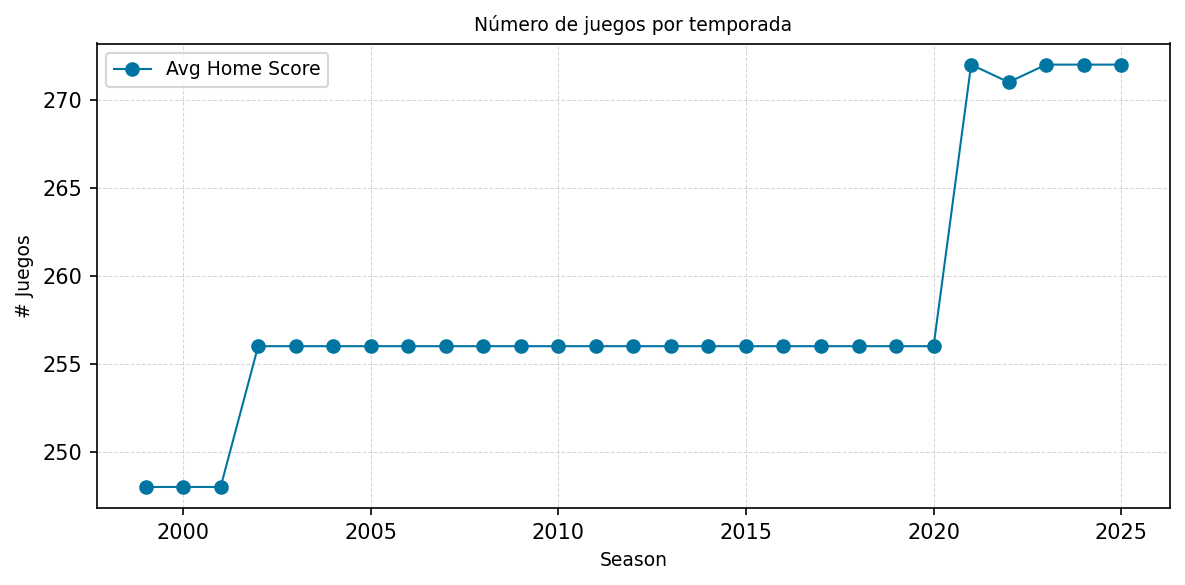

In [16]:
# Fig: Número de partidos
fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)

plt.plot(season['season'], season['game_id'], marker = 'o', color = '#0075A2', label = 'Avg Home Score', linewidth = 1) 

ax.set_xlabel('Season', fontsize = label_size)
ax.set_ylabel('# Juegos', fontsize = label_size)
ax.set_title('Número de juegos por temporada', fontsize = label_size)
ax.legend(fontsize = label_size, loc = 'upper left')
ax.grid(axis = 'both', linestyle = '--', alpha = 0.5, linewidth = 0.5, zorder = -1)
plt.tight_layout()
plt.show()

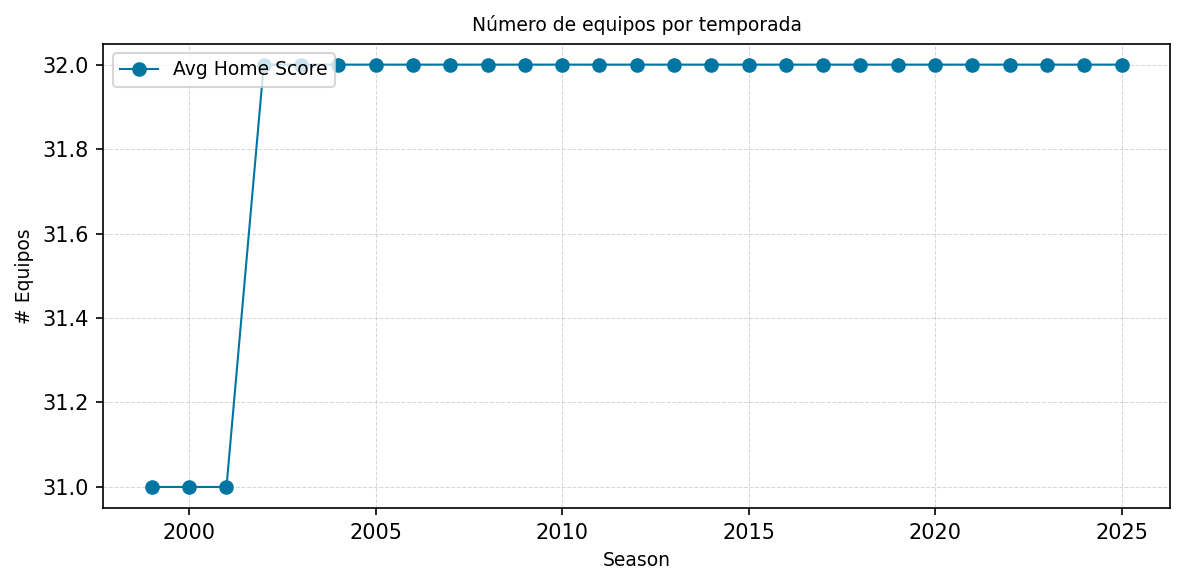

In [17]:
# Fig
fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)

plt.plot(season['season'], season['home_team'], marker = 'o', color = '#0075A2', label = 'Avg Home Score', linewidth = 1) 

ax.set_xlabel('Season', fontsize = label_size)
ax.set_ylabel('# Equipos', fontsize = label_size)
ax.set_title('Número de equipos por temporada', fontsize = label_size)
ax.legend(fontsize = label_size, loc = 'upper left')
ax.grid(axis = 'both', linestyle = '--', alpha = 0.5, linewidth = 0.5, zorder = -1)
plt.tight_layout()
plt.show()

### Heatmap: Partidos por día de la semana y hora

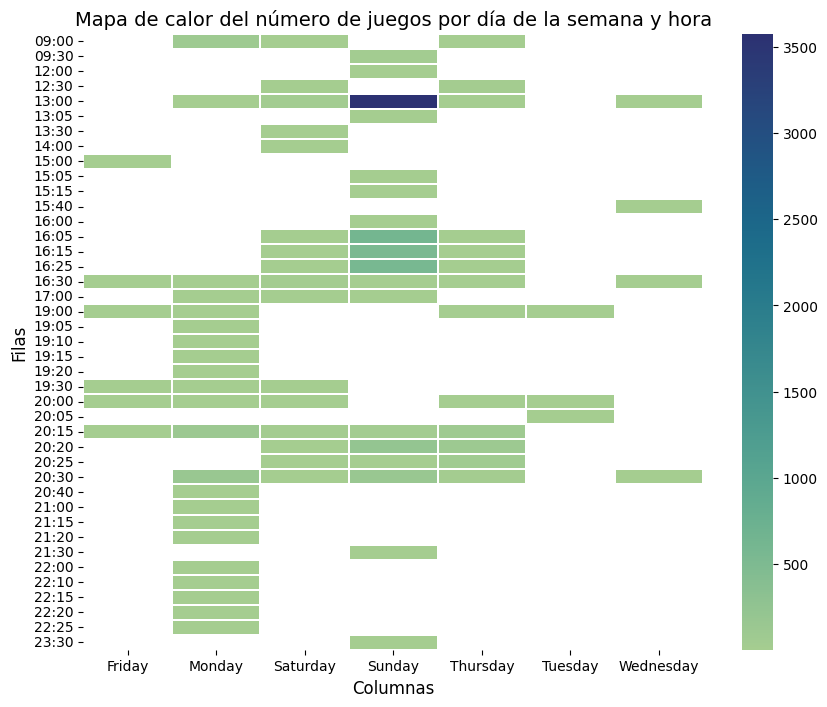

In [18]:
pivot = t.pivot_table(index = 'gametime', columns = 'weekday', values = 'game_id', aggfunc = 'count')

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=False, fmt=",0", cmap="crest", cbar=True, linewidth = 0.01)

# Configurar etiquetas y título
plt.title('Mapa de calor del número de juegos por día de la semana y hora', fontsize=14)
plt.xlabel('Columnas', fontsize=12)
plt.ylabel('Filas', fontsize=12)

# Mostrar el gráfico
plt.show()

# La gran mayoría de juegos son los domingos a las 13:00 hrs

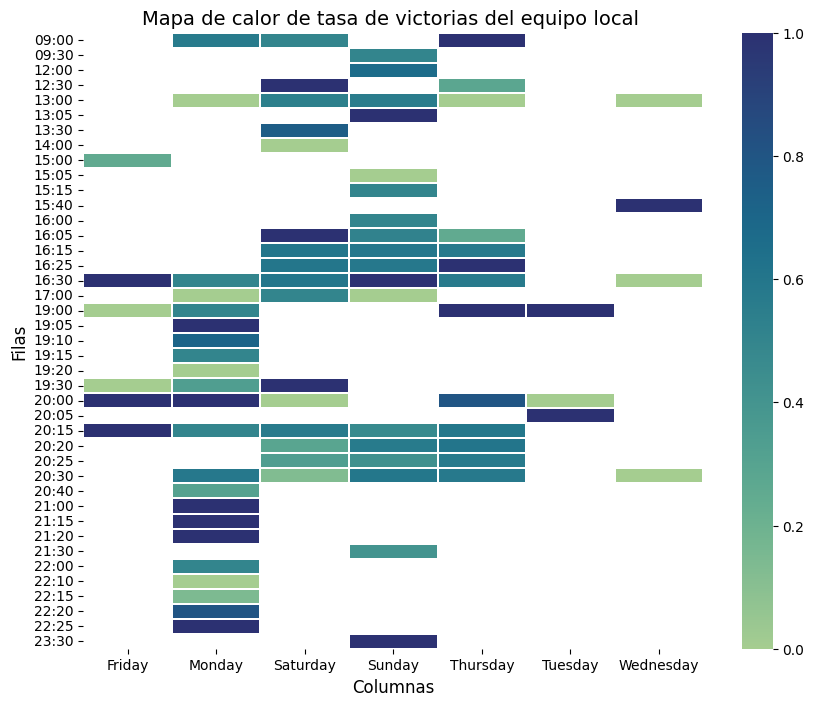

In [19]:
pivot = t.pivot_table(index = 'gametime', columns = 'weekday', values = 'home_team_win', aggfunc = 'mean')

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=False, fmt=",0", cmap="crest", cbar=True, linewidth = 0.01)

# Configurar etiquetas y título
plt.title('Mapa de calor de tasa de victorias del equipo local ', fontsize=14)
plt.xlabel('Columnas', fontsize=12)
plt.ylabel('Filas', fontsize=12)

# Mostrar el gráfico
plt.show()


In [20]:
## Hay muy pocos juegos en Viernes, martes y miércoles, por lo que los vería como "días atípicos".
# La mayoría está en domingo, depués sigue el lunes, jueves y sábado. 

# Considero que podríamos prescindir de juegos de días como viernes, martes y miércoles ya que no aportan mucha información. Son cerca de 19 juegos = 0.27% de los juegos
# Hay una ligera mejora en la tasa de victorias del equipo local por día de la semana, veamos así: 

# Lunes: 54%
# Jueves: 57%
# Sábado: 51%
# Domingo: 56%

weekday = t.groupby(['weekday']).agg({'home_team_win': 'mean', 'game_id': 'count'}).reset_index()

Veamos si el número de días ha cambiado por temporada, puede que la estructura sea diferente

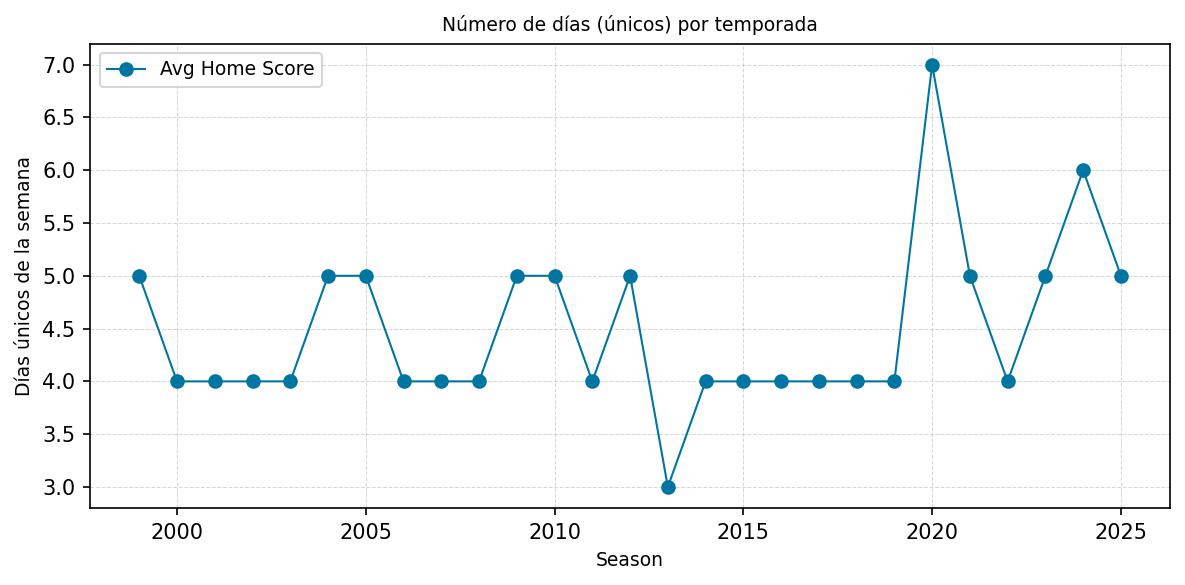

In [21]:
season = t.groupby(['season'])['weekday'].nunique().reset_index()

fig, ax = plt.subplots(figsize = (8, 4), dpi = 150)

plt.plot(season['season'], season['weekday'], marker = 'o', color = '#0075A2', label = 'Avg Home Score', linewidth = 1) 

ax.set_xlabel('Season', fontsize = label_size)
ax.set_ylabel('Días únicos de la semana', fontsize = label_size)
ax.set_title('Número de días (únicos) por temporada', fontsize = label_size)
ax.legend(fontsize = label_size, loc = 'upper left')
ax.grid(axis = 'both', linestyle = '--', alpha = 0.5, linewidth = 0.5, zorder = -1)
plt.tight_layout()
plt.show()

# Tenemos un pico en temporada 2020, lo cual debe estar relacionado con la pandemia. 

In [22]:
print('Comparativo de tasa de victorias pre, durante y post pandemia')
t['PANDEMIC_SITUATION'] = -1
t.loc[t['season'] == 2020, 'PANDEMIC_SITUATION'] = 0
t.loc[t['season'] > 2020, 'PANDEMIC_SITUATION'] = 1

Comparativo de tasa de victorias pre, durante y post pandemia


In [23]:
agg = t.groupby(['weekday', 'PANDEMIC_SITUATION']).agg({'home_team_win': 'mean', 'game_id': 'count'}).reset_index()
agg['size_pct'] = (agg['game_id'] / agg['game_id'].sum() ) * 100
agg

,weekday,PANDEMIC_SITUATION,home_team_win,game_id,size_pct
0,Friday,-1,0.250000,4,0.057414
1,Friday,0,1.000000,1,0.014353
2,Friday,1,0.600000,5,0.071767
3,Monday,-1,0.556180,356,5.109803
4,Monday,0,0.300000,20,0.287068
5,Monday,1,0.530612,98,1.406631
6,Saturday,-1,0.495050,101,1.449691
7,Saturday,0,0.200000,5,0.071767
8,Saturday,1,0.595238,42,0.602842
9,Sunday,-1,0.571092,4670,67.030286


In [24]:
t.groupby(['PANDEMIC_SITUATION']).agg({'home_team_win': 'mean', 'game_id': 'count'}).reset_index()

,PANDEMIC_SITUATION,home_team_win,game_id
0,-1,0.568946,5352
1,0,0.496094,256
2,1,0.539367,1359


In [25]:
pd.pivot_table(data = t, index = 'weekday', columns = 'PANDEMIC_SITUATION', values = 'home_team_win', aggfunc = 'mean')

PANDEMIC_SITUATION,-1,0,1
weekday,,,
Friday,0.250000,1.000000,0.600000
Monday,0.556180,0.300000,0.530612
Saturday,0.495050,0.200000,0.595238
Sunday,0.571092,0.516432,0.535907
Thursday,0.589041,0.428571,0.562500
Tuesday,0.000000,1.000000,1.000000
Wednesday,0.000000,1.000000,0.000000


### Histogramas

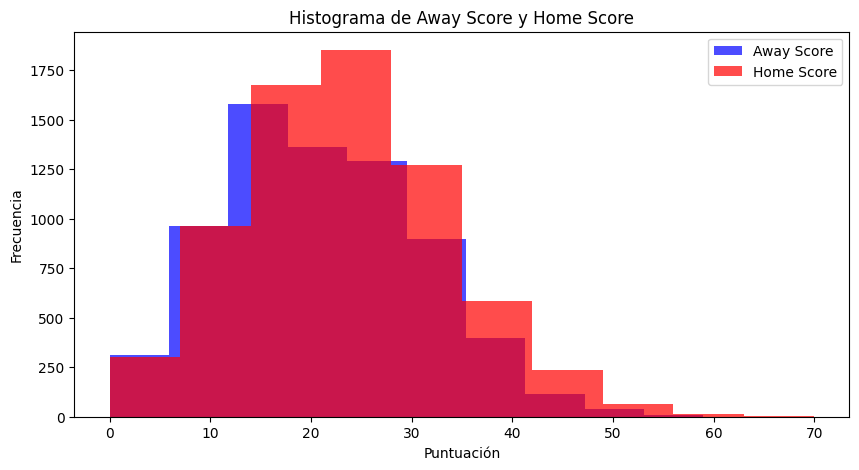

In [26]:
# Histograma para 'away_score'
plt.figure(figsize=(10, 5))
plt.hist(t['away_score'], bins=10, alpha=0.7, color='blue', label='Away Score')
plt.hist(t['home_score'], bins=10, alpha=0.7, color='red', label='Home Score')
plt.title('Histograma de Away Score y Home Score')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

<BarContainer object of 32 artists>

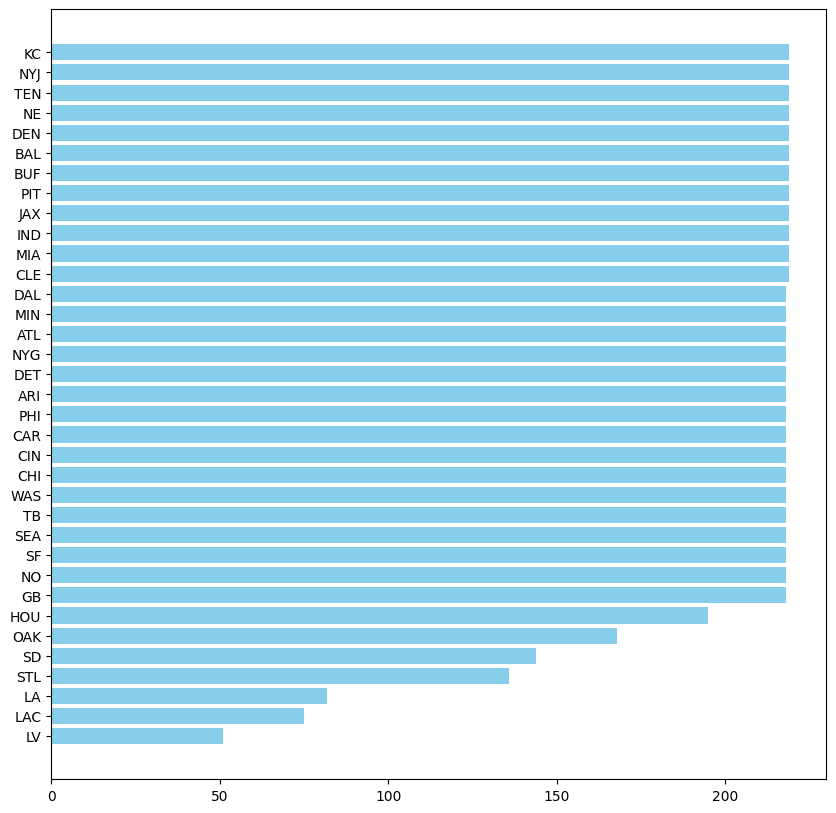

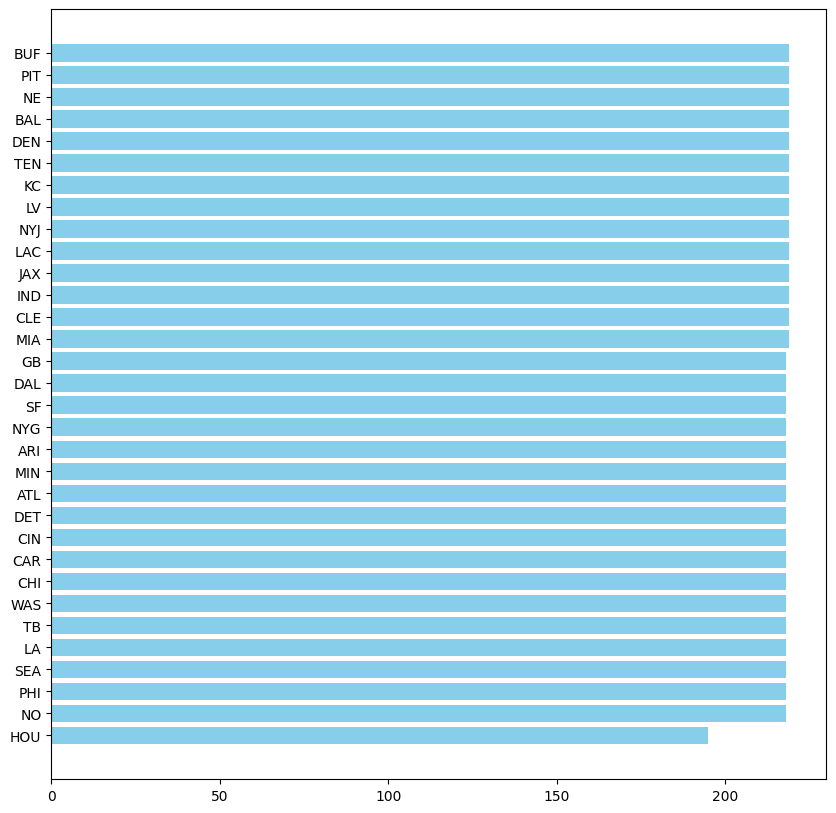

In [27]:
teams_labels = t['home_team'].value_counts().sort_values()

plt.figure(figsize=(10, 10))
plt.barh(teams_labels.index, teams_labels.values, color='skyblue')

# Hay un par de franquicias que han cambiado de "etiqueta"
# Observando la gráfica se observa que hay equipos "con más juegos"
# El único equipo con menor juegos debería ser HOU porque se creó después de 1999
# Las etiquetas: OAK, SD, STL, LA, LAC y LV son etiquetas que han sido utilizadas por diferentes franquicias a lo largo del tiempo, lo que puede generar confusión al analizar los datos.
# Vamos a "homologarlas"

franchise_map = {
    # Rams
    "STL": "LA",
    "LA": "LA",
    "LAR": "LA",

    # Raiders
    "OAK": "LV",
    "LV": "LV",
    "LVR": "LV",

    # Chargers
    "SD": "LAC",
    "LAC": "LAC"
}

t["home_team"] = t["home_team"].replace(franchise_map)
t["away_team"] = t["away_team"].replace(franchise_map)

teams_labels = t['home_team'].value_counts().sort_values()

plt.figure(figsize=(10, 10))
plt.barh(teams_labels.index, teams_labels.values, color='skyblue')

In [28]:
def compute_elo(df, K=20, HOME_ADV=60, regression=0.25, use_mov=True):
    
    df['gameday'] = pd.to_datetime(df['gameday'])
    df = df.sort_values('gameday').copy()
    
    teams = pd.unique(df[['home_team','away_team']].values.ravel())
    elo = {team: 1500 for team in teams}
    
    elo_home_pre = []
    elo_away_pre = []
    
    current_season = None
    
    for idx, row in df.iterrows():
        
        season = row['season']
        
        # --- Offseason regression ---
        if current_season is not None and season != current_season:
            for team in elo:
                elo[team] = (1 - regression)*elo[team] + regression*1500
        
        current_season = season
        
        home = row['home_team']
        away = row['away_team']
        
        R_home = elo[home]
        R_away = elo[away]
        
        # Guardamos rating previo
        elo_home_pre.append(R_home)
        elo_away_pre.append(R_away)
        
        # Ajuste localía
        R_home_adj = R_home + HOME_ADV
        
        # Probabilidad esperada
        P_home = 1 / (1 + 10 ** ((R_away - R_home_adj) / 400))
        
        # Resultado real
        S_home = 1 if row['home_score'] > row['away_score'] else 0
        
        # ---- Margen de victoria ----
        if use_mov:
            margin = abs(row['home_score'] - row['away_score'])
            mov_multiplier = np.log(margin + 1)
        else:
            mov_multiplier = 1
        
        # Actualización
        elo[home] = R_home + K * mov_multiplier * (S_home - P_home)
        elo[away] = R_away + K * mov_multiplier * ((1 - S_home) - (1 - P_home))
    
    df['elo_home_pre'] = elo_home_pre
    df['elo_away_pre'] = elo_away_pre
    df['elo_diff_pre'] = df['elo_home_pre'] - df['elo_away_pre']
    
    return df

In [29]:
x = compute_elo(t)

In [30]:
rams = x.query((" (home_team.isin(['LA', 'STL'])) | (away_team.isin(['LA', 'STL'])) "))

In [31]:
agg_rams = rams.loc[:, ['season', 'gameday', 'home_team', 'away_team', 'home_score', 'away_score', 'elo_home_pre', 'elo_away_pre', 'elo_diff_pre']]